In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from datasist.structdata import detect_outliers

In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(rc={'figure.figsize': [8, 5]}, font_scale=1.2)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
X_train = pd.read_csv('datasets/cancer_data/train_data.csv')
y_train = pd.read_csv('datasets/cancer_data/train_labels.csv')
X_val = pd.read_csv('datasets/cancer_data/val_data.csv')
y_val = pd.read_csv('datasets/cancer_data/val_labels.csv')
X_test = pd.read_csv('datasets/cancer_data/test_data.csv')
y_test = pd.read_csv('datasets/cancer_data/test_labels.csv')

In [4]:
print('Data Len: ',len(X_train),'  Label Len: ',len(y_train))

Data Len:  390   Label Len:  390


In [5]:
# === merge 2 dataframes 'data' and 'labels' ===
cancer_df = pd.concat([X_train, y_train],axis=1)

In [6]:
cancer_df

,age,famhistory,marker,cancer
0,63.789,0,0.727,1
1,60.211,0,0.365,0
2,70.187,1,1.271,1
3,64.857,1,1.000,0
4,68.658,0,0.837,0
...,...,...,...,...
385,72.496,0,1.993,1
386,58.663,0,0.246,0
387,62.632,0,0.545,0
388,69.776,0,2.523,1


## Data Exploration

In [7]:
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         390 non-null    float64
 1   famhistory  390 non-null    int64  
 2   marker      390 non-null    float64
 3   cancer      390 non-null    int64  
dtypes: float64(2), int64(2)
memory usage: 12.3 KB


In [8]:
cancer_df.describe()

,age,famhistory,marker,cancer
count,390.000,390.000,390.000,390.000
mean,64.922,0.164,1.012,0.141
std,4.832,0.371,1.012,0.348
min,45.304,0.000,0.001,0.000
25%,61.764,0.000,0.301,0.000
50%,65.088,0.000,0.703,0.000
75%,68.278,0.000,1.403,0.000
max,79.767,1.000,6.721,1.000


In [9]:
cancer_df.isnull().sum()

age           0
famhistory    0
marker        0
cancer        0
dtype: int64

In [10]:
# Display percentages on countplot charts, handle displaying of chart in case of using "hue"
def display_countplot_percent(df, ax, hue=False):
    '''
    display_countplot_percent(): Add percentages on top of bars plots
    args:
        df: pandas dataframe
        ax: Axes object (Countplot)
        hue: boolean, False by default using in case of ploting with hue
    '''
    df_len = int(len(df))
    for patch in ax.patches:
        patch_height = patch.get_height() if not np.isnan(patch.get_height()) else 0
        percent_txt = '{:.2f}%'.format(100 * patch_height /df_len)
        new_x = patch.get_x() if hue else patch.get_x() + patch.get_width() / 2.7
        new_y = patch_height
        ax.text(new_x, new_y, percent_txt)

## Data Analysis
> ### Univariate Anlaysis
> ### Categorical attributes
> #### famhistory, cancer

> ### Cancer
>> #### What is the percentage of cancer?

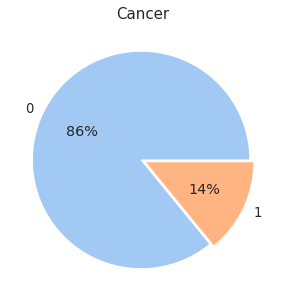

In [11]:
plt.title('Cancer', fontsize=15)
explode = [0.02, 0.02]
data = list(cancer_df['cancer'].value_counts().values)
labels = list(cancer_df['cancer'].value_counts().index)
colors = sns.color_palette('pastel')[0:5]
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%', explode=explode);

- 14% only have cancer, imbalanced dataset

> ### Family History
>> #### What is the percentage of family history?
>> #### What is the percentage of positive family history and cancer?

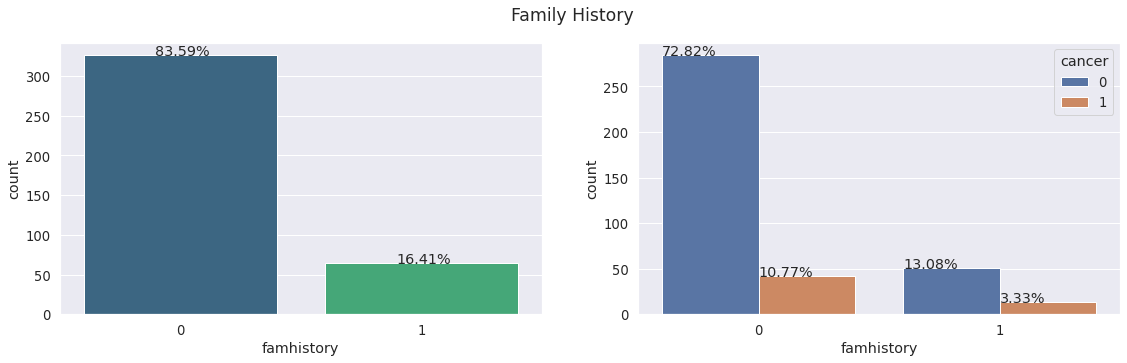

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(19, 5)) 
fig.suptitle('Family History') 
ax_0=sns.countplot(ax=axes[0], data=cancer_df, x='famhistory', palette='viridis', order=cancer_df['famhistory'].value_counts().index)
display_countplot_percent(cancer_df, ax_0)
ax_1=sns.countplot(ax=axes[1], x='famhistory', data=cancer_df, hue='cancer')
display_countplot_percent(cancer_df, ax_1, True)

- 16% have positive family history
- 13% with negative family history has cancer
- 20% with positive family history has cancer

> ### Numeric attributes
> #### Age, marker

> ### Age
>> #### What is the distribution of age?
>> #### Is there any outliers?

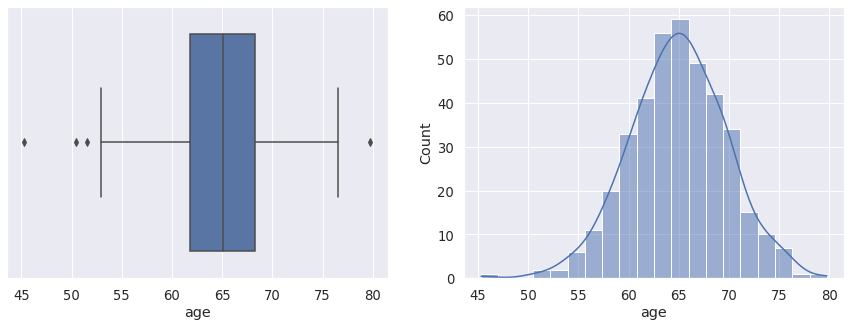

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 
sns.boxplot(cancer_df["age"], ax=axes[0])
sns.histplot(data=cancer_df, x="age", kde=True, ax=axes[1]);

- Normal distribution with little left skewness
- Age range above 50
- Few outliers, 4 records, 3 lower and 1 upper

In [14]:
has_cancer_df=cancer_df[cancer_df['cancer']==1]
hasnot_cancer_df=cancer_df[cancer_df['cancer']==0]
has_cancer_df.describe()['age']

count   55.000
mean    68.915
std      4.262
min     61.473
25%     66.064
50%     69.005
75%     71.848
max     79.767
Name: age, dtype: float64

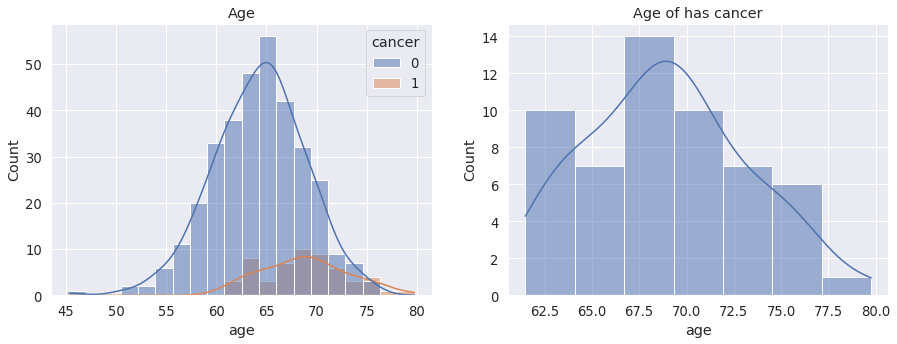

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 
sns.histplot(data=cancer_df, x="age", hue='cancer', kde=True, ax=axes[0]).set(title='Age')
sns.histplot(data=has_cancer_df, x="age", kde=True, ax=axes[1]).set(title='Age of has cancer');

- Right skewness
- Age range which has cancer strating from 61 years
- The upper oultier which has 79 years has cancer

> ### Marker
>> #### What is the distribution of marker?
>> #### Is there any outliers?

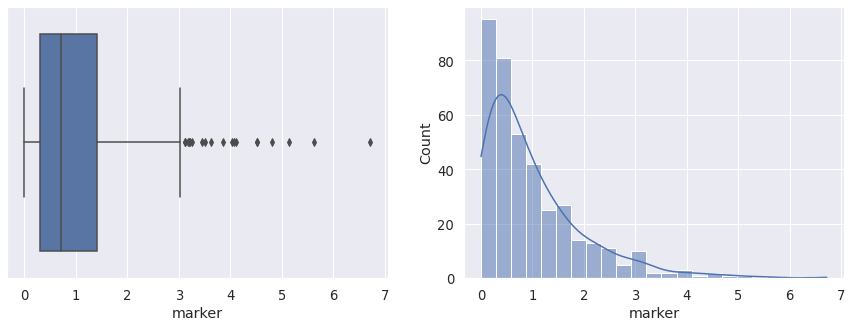

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 
sns.boxplot(cancer_df["marker"], ax=axes[0])
sns.histplot(data=cancer_df, x="marker", kde=True, ax=axes[1]);

- Strong right skewness
- Outliers above 3 

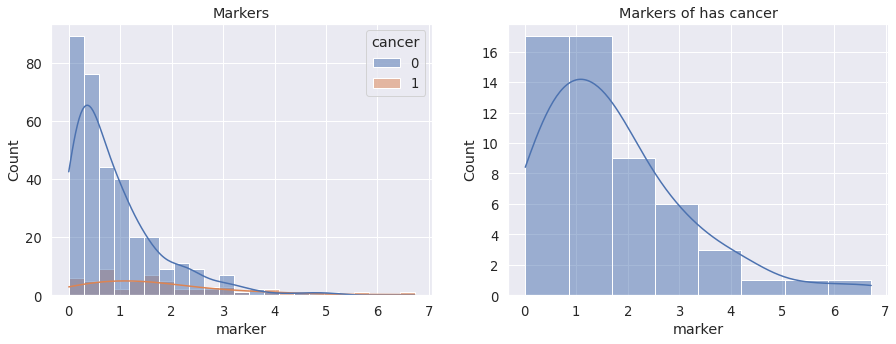

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 
sns.histplot(data=cancer_df, x="marker", hue='cancer', kde=True, ax=axes[0]).set(title='Markers')
sns.histplot(data=has_cancer_df, x="marker", kde=True, ax=axes[1]).set(title='Markers of has cancer');

In [18]:
has_cancer_df.describe()['marker']

count   55.000
mean     1.738
std      1.430
min      0.013
25%      0.726
50%      1.487
75%      2.326
max      6.721
Name: marker, dtype: float64

In [19]:
hasnot_cancer_df.describe()['marker']

count   335.000
mean      0.893
std       0.872
min       0.001
25%       0.271
50%       0.605
75%       1.183
max       5.135
Name: marker, dtype: float64

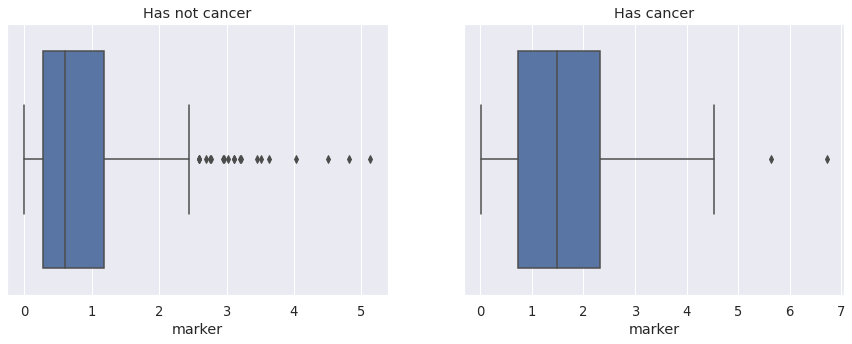

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 
sns.boxplot(data=hasnot_cancer_df, x="marker", ax=axes[0]).set(title='Has not cancer')
sns.boxplot(data=has_cancer_df, x="marker", ax=axes[1]).set(title='Has cancer');

- 75% of markers of patients have not cancer till 1.18 and maximum marker is 5.1
- On the other hand patients have cancer have higher markers, 75% till 2.3 and maximum marker is 6.7
- Range of markers of patients with cancer is greater than other

> ### Bivariate and Multivariate Anlaysis

> #### Relation between Cancer, Family History and Markers

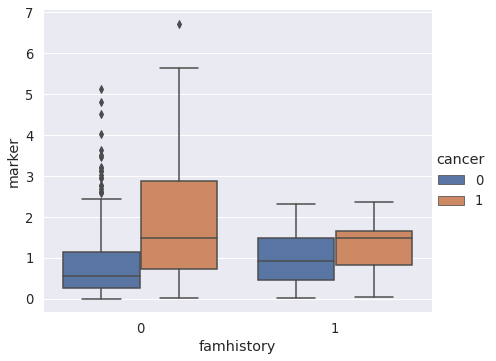

In [21]:
sns.catplot(x="famhistory", y="marker", data=cancer_df, height=5, aspect=1.2, hue="cancer", kind="box");

- Surprisingly the patients with cancer and highest markers have negative family history, all above 3 markers have negative family history

> #### Relation between Cancer, Family History and Age

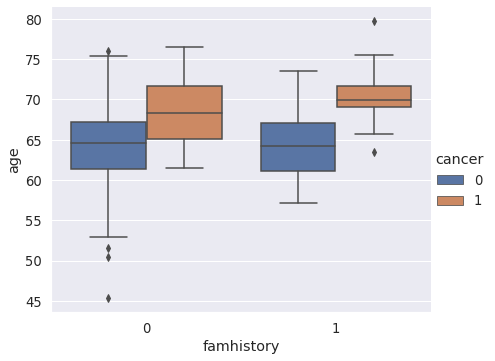

In [22]:
sns.catplot(x="famhistory", y="age", data=cancer_df, height=5, aspect=1.2, hue="cancer", kind="box");

- In both cases of having positive or negative family history, ages of patients with  malignant are the highest

> #### Relation between all numeric features

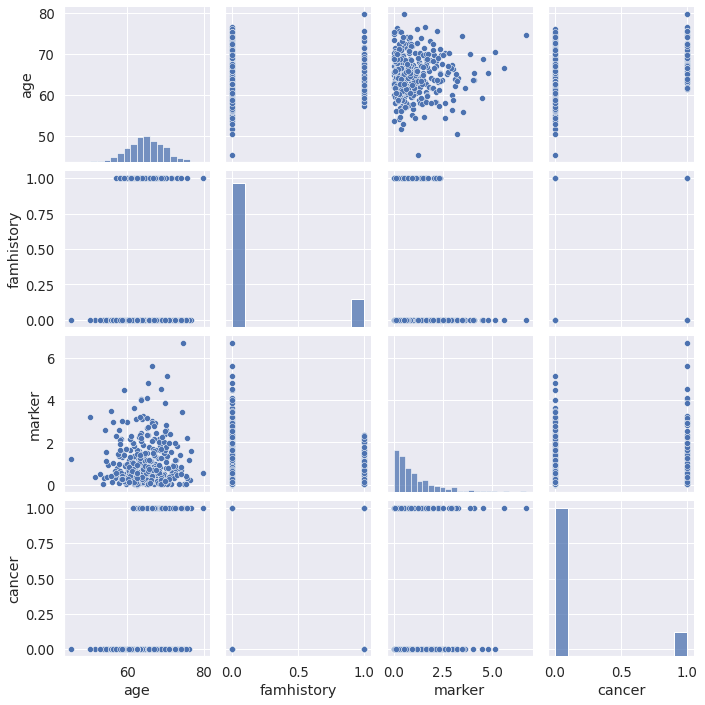

In [23]:
sns.pairplot(cancer_df);

- Higher ages above 60 have cancers more
- Highest markers have cancer

## Data Preprocessing 

In [24]:
cp_df=cancer_df.copy()

> ### Duplicated Values

In [25]:
cp_df[cp_df.duplicated()]

,age,famhistory,marker,cancer


> ### Outliers

In [26]:
def get_outliers_data(df , col):
    outliers = detect_outliers(df, 0, [col])
    c_len = len(list(cp_df.loc[outliers, col]))
    c_min=cp_df.loc[outliers, col].min()
    c_max=cp_df.loc[outliers, col].max()
    print('MIN ',c_min,' MAX ',c_max, ' No. Of Outliers ', c_len)
    return cp_df.iloc[outliers]

>> #### Age

In [27]:
outliers_df = get_outliers_data(cp_df , 'age')

MIN  45.30359  MAX  79.76653  No. Of Outliers  4


In [28]:
outliers_df

,age,famhistory,marker,cancer
122,45.304,0,1.219,0
133,51.556,0,0.371,0
227,50.482,0,3.203,0
311,79.767,1,0.534,1


In [29]:
cp_df.describe()['age']

count   390.000
mean     64.922
std       4.832
min      45.304
25%      61.764
50%      65.088
75%      68.278
max      79.767
Name: age, dtype: float64

In [30]:
cp_df[cp_df['age'] > 51.5556]['age'].min()

52.96059

In [31]:
cp_df[cp_df['age'] > 51.5556]['age'].sort_values()

248   52.961
165   53.736
60    54.021
31    54.343
243   54.456
       ...  
346   75.560
222   76.000
32    76.315
36    76.532
311   79.767
Name: age, Length: 387, dtype: float64

In [32]:
cp_df["age"] = cp_df["age"].apply(lambda x: 52.96059 if x < 52.96059 else x)

In [33]:
cp_df['age'].min()

52.96059

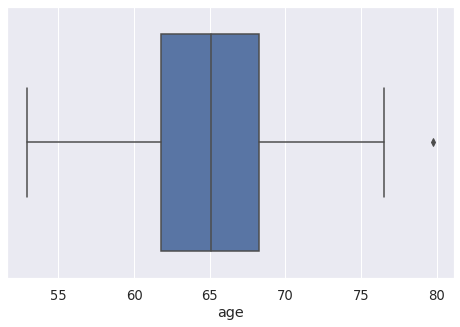

In [34]:
sns.boxplot(data=cp_df,x=cp_df['age']);

>> #### Marker

In [35]:
outliers_df = get_outliers_data(cp_df , 'marker')

MIN  3.110172  MAX  6.721334  No. Of Outliers  19


In [36]:
outliers_df['cancer'].value_counts()

0    11
1     8
Name: cancer, dtype: int64

In [37]:
outliers_df[outliers_df['cancer']==1]

,age,famhistory,marker,cancer
80,63.700,0,4.074,1
129,64.171,0,3.258,1
146,65.244,0,4.105,1
162,69.963,0,3.866,1
182,74.577,0,6.721,1
225,65.087,0,3.184,1
236,68.833,0,4.524,1
314,66.417,0,5.630,1


In [38]:
outliers_df[outliers_df['cancer']==0]

,age,famhistory,marker,cancer
44,70.398,0,5.135,0
92,61.691,0,3.630,0
178,63.965,0,3.116,0
184,62.240,0,3.110,0
197,59.294,0,4.509,0
227,52.961,0,3.203,0
244,63.628,0,4.030,0
265,65.349,0,4.818,0
266,55.695,0,3.514,0
328,63.319,0,3.210,0


In [39]:
cp_df["marker"] = cp_df["marker"].apply(lambda x: 5.630 if x >= 6.721 else x)

In [40]:
cp_df["marker"].max()

5.630261

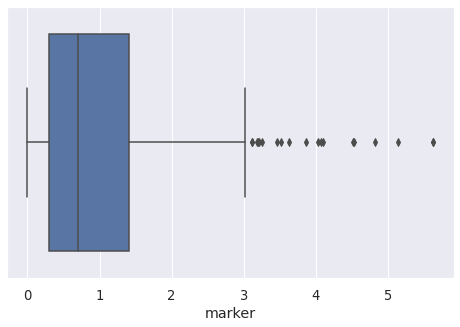

In [41]:
sns.boxplot(data=cp_df,x=cp_df['marker']);

> ### Correlation 

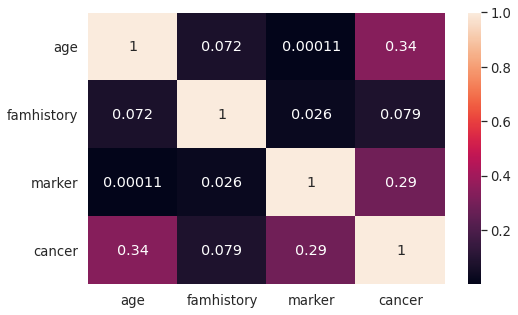

In [42]:
sns.heatmap(cp_df.corr(), annot=True);

- weak positive correlation between age and cancer 0.34, marker and cancer 0.29

> ### Feature Scaling

In [43]:
cols = list(cp_df.columns)
cols.remove('cancer')

X_train = cp_df[cols]
y_train = cp_df['cancer']

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

scaler = StandardScaler().fit(X_val)
X_val = scaler.transform(X_val)

scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

In [44]:
X_train

array([[-0.24566687, -0.44307902, -0.28313888],
       [-1.00142242, -0.44307902, -0.64741025],
       [ 1.10604096,  2.25693376,  0.26269036],
       ...,
       [-0.48998687, -0.44307902, -0.46608785],
       [ 1.01929538, -0.44307902,  1.52007194],
       [-0.94564413, -0.44307902, -0.90719204]])

In [45]:
# === famhistory & marker ===
X_train[:,1:]

array([[-4.43079020e-01, -2.83138880e-01],
       [-4.43079020e-01, -6.47410252e-01],
       [ 2.25693376e+00,  2.62690358e-01],
       [ 2.25693376e+00, -9.77567036e-03],
       [-4.43079020e-01, -1.73278161e-01],
       [-4.43079020e-01,  5.38189631e-01],
       [-4.43079020e-01, -1.00374878e+00],
       [-4.43079020e-01, -6.16213262e-01],
       [-4.43079020e-01, -9.01256168e-02],
       [ 2.25693376e+00,  9.87463839e-01],
       [-4.43079020e-01,  3.02267730e-01],
       [-4.43079020e-01,  7.71748839e-01],
       [-4.43079020e-01, -4.14781361e-01],
       [-4.43079020e-01, -9.15117256e-01],
       [-4.43079020e-01, -7.83424569e-01],
       [ 2.25693376e+00,  4.58622195e-01],
       [-4.43079020e-01, -4.10490356e-01],
       [-4.43079020e-01, -1.57608675e-01],
       [-4.43079020e-01,  9.61440797e-02],
       [ 2.25693376e+00, -3.10985123e-01],
       [ 2.25693376e+00, -1.08346148e-02],
       [ 2.25693376e+00, -9.91401623e-01],
       [-4.43079020e-01, -6.10993046e-01],
       [-4.

### Buiding Model

In [46]:
def eval_model(model, X_train, y_train, X_val, y_val):
    y_pred = model.predict(X_val)
    scores_dic={"Classifier": type(model).__name__,
        "Training Score" : model.score(X_train, y_train),
        "Testing Score" : model.score(X_val, y_val)}
    scores_df = pd.DataFrame([scores_dic]).set_index(['Classifier'])
    return scores_df, y_pred


def plot_confusion_matrix(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.show()

> ### Logistic Regression
>> #### Without "Age"

In [47]:
log_model = LogisticRegression().fit(X_train[:,1:], y_train)
log_data = eval_model(log_model, X_train[:,1:], y_train, X_val[:,1:], y_val)
log_data[0]

,Training Score,Testing Score
Classifier,,
LogisticRegression,0.859,0.867


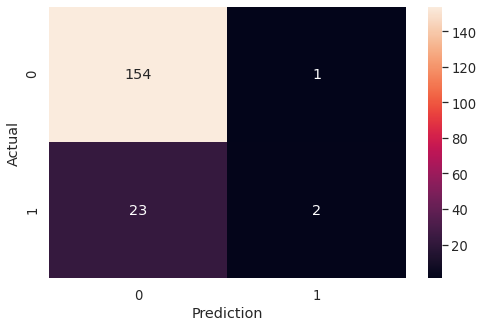

In [48]:
plot_confusion_matrix(y_val, log_data[1])

>> #### All Features

In [49]:
log_model = LogisticRegression().fit(X_train, y_train)
log_data = eval_model(log_model, X_train, y_train, X_val, y_val)
log_data[0]

,Training Score,Testing Score
Classifier,,
LogisticRegression,0.864,0.894


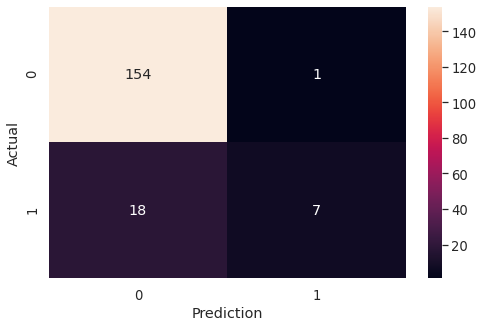

In [50]:
plot_confusion_matrix(y_val, log_data[1])

- Increasing in training and testing scores after training on all featuers without excluding "Age"

> ### KNN Classifier
>> #### Without "Age"

In [51]:
knn_model = KNeighborsClassifier().fit(X_train[:,1:], y_train)
knn_data = eval_model(knn_model, X_train[:,1:], y_train, X_val[:,1:], y_val)
knn_data[0]

,Training Score,Testing Score
Classifier,,
KNeighborsClassifier,0.864,0.844


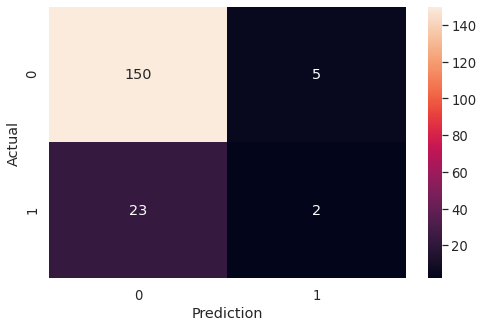

In [52]:
plot_confusion_matrix(y_val, knn_data[1])

>> #### All Features

In [53]:
knn_model = KNeighborsClassifier().fit(X_train, y_train)
knn_data = eval_model(knn_model, X_train, y_train, X_val, y_val)
knn_data[0]

,Training Score,Testing Score
Classifier,,
KNeighborsClassifier,0.885,0.889


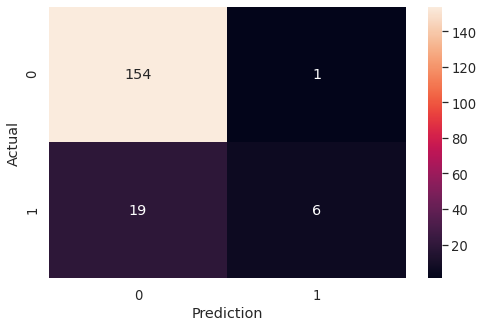

In [54]:
plot_confusion_matrix(y_val, knn_data[1])

- Increasing in training and testing scores after training on all featuers without excluding "Age"

>> #### KNN Hyper-parameter

In [55]:
test_score_dic={}
for i in range(5, 50, 5):
    print('K = ',i)
    knn_model = KNeighborsClassifier(n_neighbors=i).fit(X_train, y_train)
    knn_data = eval_model(knn_model, X_train, y_train, X_val, y_val)
    print(knn_data[0])
    print('========================================================')
    if test_score_dic:
        if knn_data[0]['Testing Score'].values[0] > list(test_score_dic.values())[0]:
            test_score_dic[i] = knn_data[0]['Testing Score'].values[0]
    else:
        test_score_dic[i] = knn_data[0]['Testing Score'].values[0]

K =  5
                      Training Score  Testing Score
Classifier                                         
KNeighborsClassifier           0.885          0.889
K =  10
                      Training Score  Testing Score
Classifier                                         
KNeighborsClassifier           0.885          0.872
K =  15
                      Training Score  Testing Score
Classifier                                         
KNeighborsClassifier           0.874          0.867
K =  20
                      Training Score  Testing Score
Classifier                                         
KNeighborsClassifier           0.864          0.861
K =  25
                      Training Score  Testing Score
Classifier                                         
KNeighborsClassifier           0.856          0.861
K =  30
                      Training Score  Testing Score
Classifier                                         
KNeighborsClassifier           0.859          0.861
K =  35
         

In [56]:
k=list(test_score_dic.keys())[0]
print('Best Testing Score: ',test_score_dic[k], ' ,K=', k)

Best Testing Score:  0.8888888888888888  ,K= 5


- By increasing number of "K" both training and testing scores decreased

> ### Comparing Models

In [57]:
knn_model = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
knn_data = eval_model(knn_model, X_train, y_train, X_val, y_val)
pd.concat([log_data[0], knn_data[0]])

,Training Score,Testing Score
Classifier,,
LogisticRegression,0.864,0.894
KNeighborsClassifier,0.885,0.889


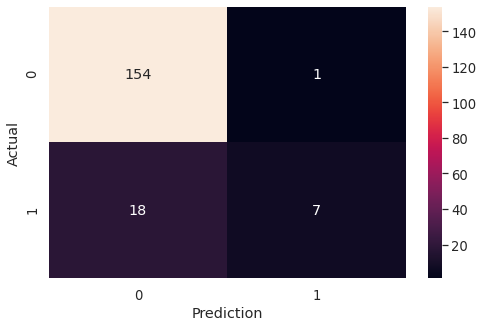

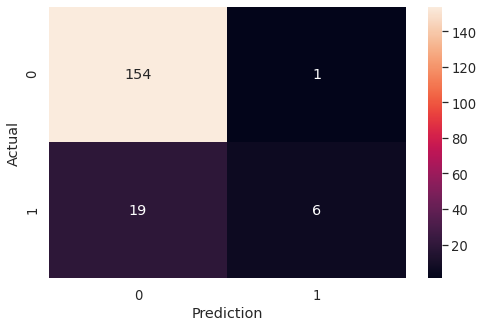

In [58]:
plot_confusion_matrix(y_val, log_data[1])
plot_confusion_matrix(y_val, knn_data[1])

- No big difference between testing scores of logistic and KNN models, but there is a diffrence in training scores as KNN training score increased by 1.8% 

> ### Testing Model 
>> #### KNN

In [59]:
knn_model = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
knn_data = eval_model(knn_model, X_train, y_train, X_test, y_test)

In [60]:
knn_data[0]

,Training Score,Testing Score
Classifier,,
KNeighborsClassifier,0.885,0.883


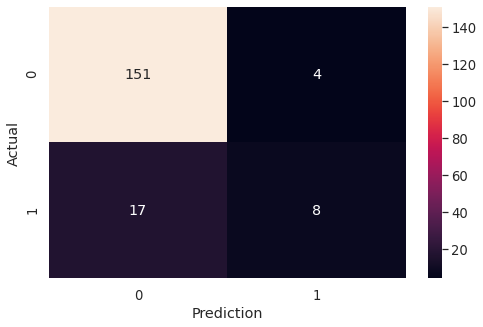

In [61]:
plot_confusion_matrix(y_test, knn_data[1])